In [2]:
import os
from dotenv import load_dotenv
from typing import Annotated

from langchain.chat_models import init_chat_model
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [3]:
load_dotenv()

True

In [4]:
AI_MODEL = os.getenv('AI_MODEL')
AI_API_KEY = os.getenv('AI_API_KEY')
llm = init_chat_model(model=AI_MODEL, api_key=AI_API_KEY)

In [5]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

def should_iterate(state: dict) -> str:
    # Stop if user/agent set a flag, or if we've hit max iters
    if state.get("should_stop", False):
        return "stop"
    it = state.get("iteration", 0)
    max_it = state.get("max_iters", 3)
    return "stop" if it >= max_it else "loop"

In [6]:
graph_builder = StateGraph(State)

graph_builder.add_node("target_selector", chatbot)
graph_builder.add_node("structure_resolver", chatbot)
graph_builder.add_node("structure_preparator", chatbot)
graph_builder.add_node("pocket_mapper", chatbot)
graph_builder.add_node("pocket_ranker", chatbot)
graph_builder.add_node("molecule_generator", chatbot)
graph_builder.add_node("medicinal_filter", chatbot)
graph_builder.add_node("docking_engine", chatbot)
graph_builder.add_node("pair_selector", chatbot)
graph_builder.add_node("af3_validator", chatbot)
graph_builder.add_node("iterator_controller", chatbot)
graph_builder.add_node("provenance_manager", chatbot)

graph_builder.add_conditional_edges(
    "iterator_controller",
    should_iterate,
    {
        "loop": "pocket_ranker",  # iterate: re-rank pockets → regenerate → redock
        "stop": END
    }
)

In [7]:
def connect(a: str, b: str):
    graph_builder.add_edge(a, "provenance_manager")
    graph_builder.add_edge("provenance_manager", b)

In [8]:
graph_builder.add_edge(START, "target_selector")
connect("target_selector", "structure_resolver")
connect("structure_resolver", "structure_preparator")
connect("structure_preparator", "pocket_mapper")
connect("pocket_mapper", "pocket_ranker")
connect("pocket_ranker", "molecule_generator")
connect("molecule_generator", "medicinal_filter")
connect("medicinal_filter", "docking_engine")
connect("docking_engine", "pair_selector")
connect("pair_selector", "af3_validator")
connect("af3_validator", "iterator_controller")

In [9]:
graph = graph_builder.compile()

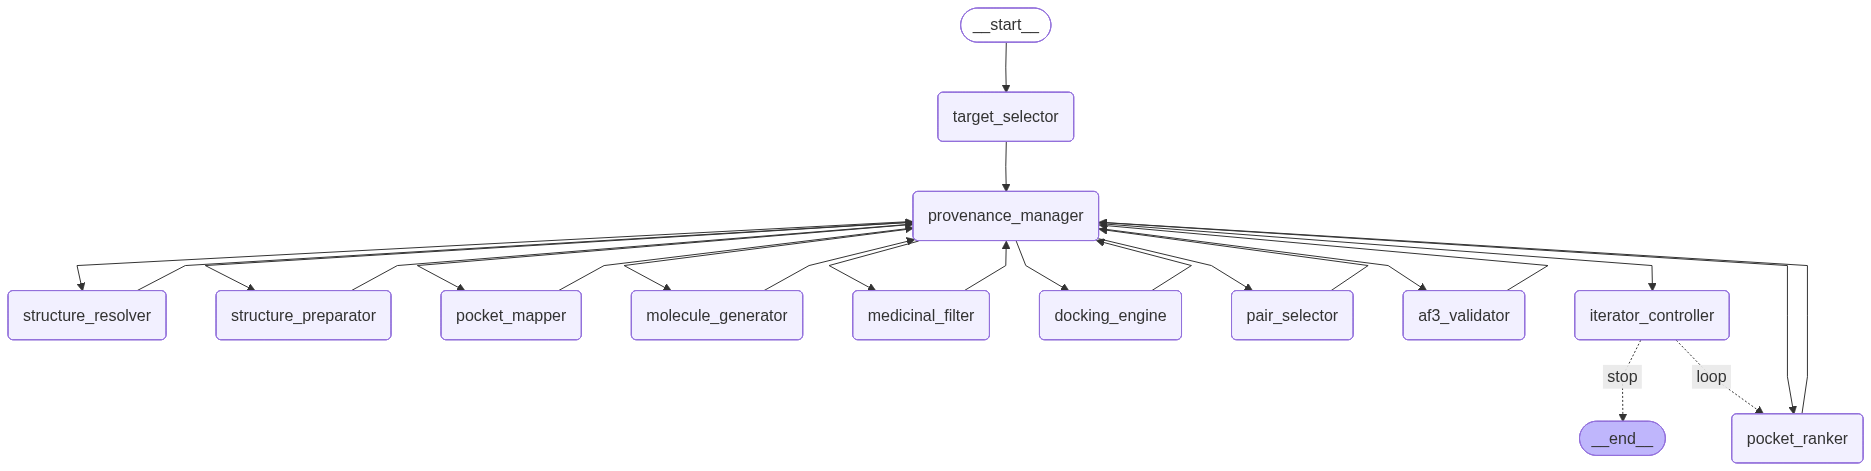

In [10]:
graph